In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import copy

source_dir = "images/"
save_dir = "save/"

In [3]:
def show_image(image, title=None, save_name=None):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    if save_name is not None:
        plt.savefig(save_dir + save_name)

In [4]:
# Apply a histogram equalization
def histogram_equalization(image):
    hist, bins = np.histogram(image.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf1 = np.ma.filled(cdf_m,0).astype('uint8')
    image = cdf1[image]
    return image

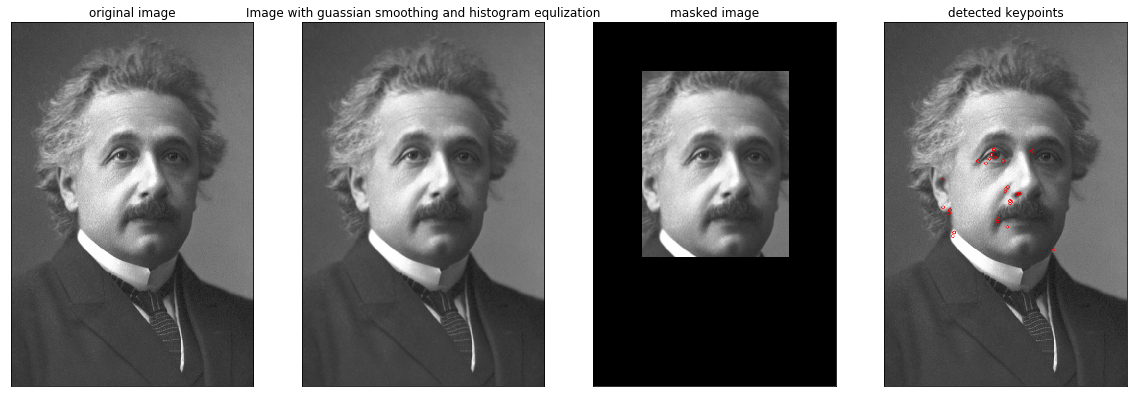

In [54]:
#### Keypoint detection using BRISK

# Reading the refrence image and appling the algorithms
reference_image = cv2.imread(source_dir + "REF.jpg")

edited_image = np.copy(reference_image)
plt.figure(figsize=(20, 10))
plt.subplot(141)
show_image(edited_image, "original image")

# Preparing the image for further operations
image = cv2.cvtColor(edited_image, cv2.COLOR_BGR2GRAY)
image = cv2.GaussianBlur(image, (3, 3), 0)
# image = histogram_equalization(image)
plt.subplot(142)
show_image(image, "Image with guassian smoothing and histogram equlization")

# Applying the brisk algorithm with a mask
brisk = cv2.BRISK_create(thresh=50, octaves=6)
mask = np.zeros_like(image)
mask[100:480, 100:400] = 255
obj_keypoints, _ = brisk.detectAndCompute(image, mask)
cv2.drawKeypoints(edited_image, obj_keypoints, edited_image, (0, 0, 255))
masked_image = cv2.bitwise_and(image, mask)
plt.subplot(143)
show_image(masked_image, "masked image")
plt.subplot(144)
show_image(edited_image, "detected keypoints")

In [61]:
def detect_and_draw(image, mask=None, smooth=True, histogram_equlization=True, keypointdetector="BRISK"):
    
    original_image = np.copy(image)

    # Preprocess the image
    image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    
    if smooth:
        image = cv2.medianBlur(image, 5)
        image = cv2.GaussianBlur(image, (3, 3), 0)
        
    if histogram_equalization:
        image = histogram_equalization(image)

    if keypointdetector == "HARRIS":
        if mask is not None:
            image = cv2.bitwise_and(image, mask)
        
        # Detecting the keypoints and drawing them
        harris = cv2.cornerHarris(image, 2, 3, 0.1)
#         harris_normal = np.empty_like(harris)
#         cv2.normalize(harris, harris_normal, 0, 255, cv2.NORM_MINMAX)
#         harris_normal = cv2.convertScaleAbs(harris_normal)
        keypoints = np.where(harris > harris.max()*0.1)
        
        for i, j in zip(keypoints[0], keypoints[1]):
            cv2.circle(original_image, (j, i), 4, (0, 0 , 255))

    elif keypointdetector == "BRISK":
        # Creating the brisk operator
        brisk = cv2.BRISK_create(thresh=70, octaves=6)
        
        # Detecting the brisk keypoints
        keypoints, _ = brisk.detectAndCompute(image, mask)
        cv2.drawKeypoints(original_image, keypoints, original_image, (0, 0, 255))
        
    else:
        raise f"unknown type of operator {keypointdetector}"
        
    return original_image, keypoints

> It is obivious that BRISK opeartor is better than the Harris keypoint detection in lots of aspects. Despite the computational superiority of the BRISK operator. The results of BRISK tends to be much more acceptable compared to Harris, specifically for this application, where the most discriminative keypoints are the edges of lips, eyes, nose and other individual parts of the face

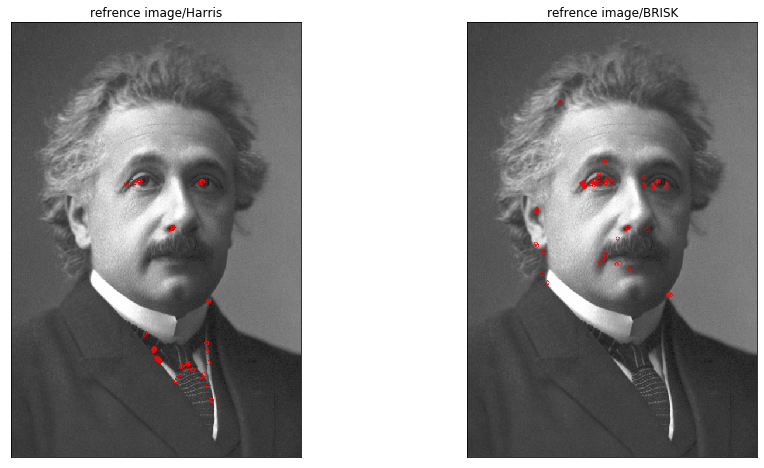

In [62]:
# Reading the refrence image and appling the algorithms
reference_image = cv2.imread(source_dir + "REF.jpg")

# Applying the keypoint detectors on the refrence image
plt.figure(figsize=[15, 8])
plt.subplot(121)
image, _ = detect_and_draw(reference_image, smooth=True, histogram_equlization=True, keypointdetector="HARRIS")
show_image(image, "refrence image/Harris")
plt.subplot(122)
image, ref_keypoints = detect_and_draw(reference_image, mask, histogram_equlization=False, smooth=False, keypointdetector="BRISK")
show_image(image, "refrence image/BRISK")

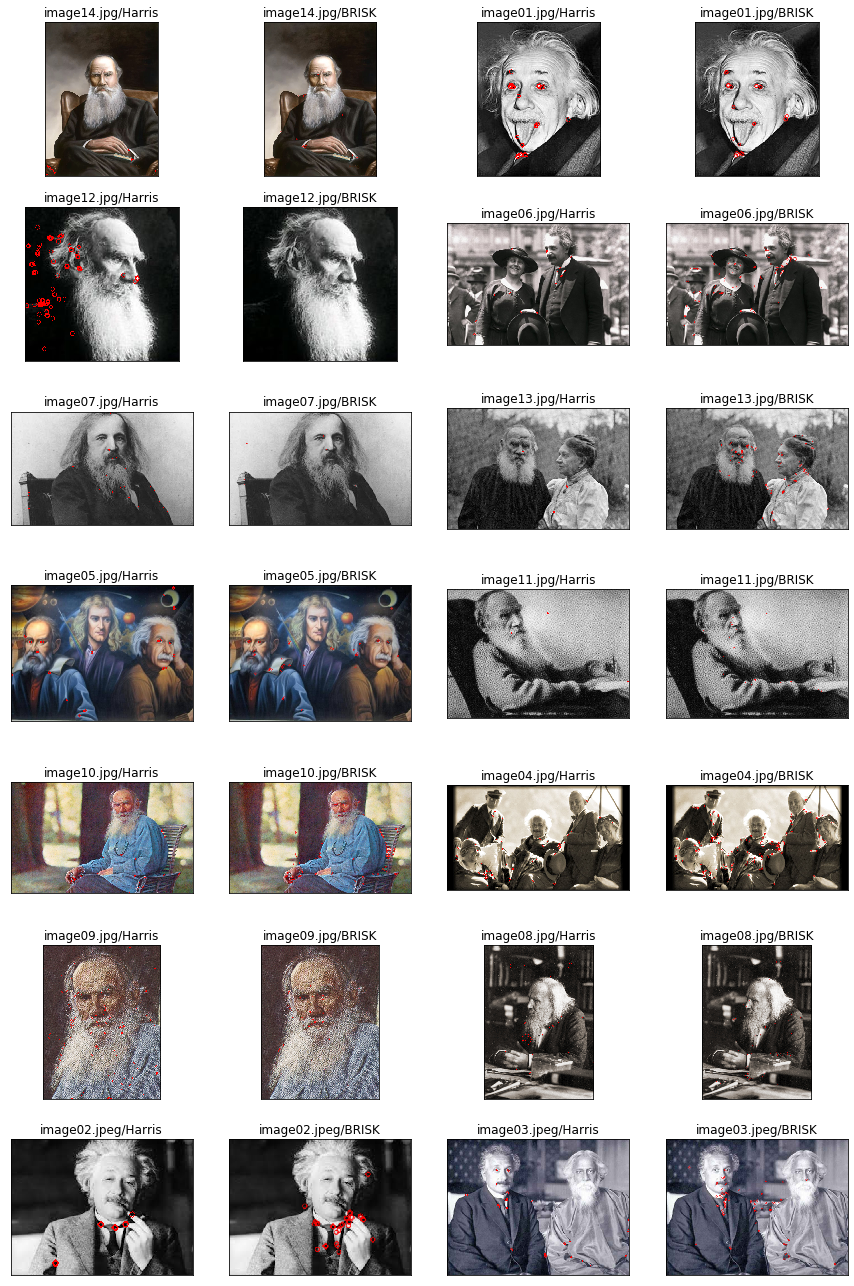

In [63]:
# Appling the above two methods on all of the images
images_list = os.listdir(source_dir)
images_list.remove('.DS_Store')

# Reading the refrence image and appling the algorithms
plt.figure(figsize=[15, 30])
images_keypoints = {}
images = {}

he = True
smoothing = True
for i in range(0, len(images_list)//2):
    plt.subplot(9, 4, 4*(i+1) + 1)
    original_image = cv2.imread(source_dir + images_list[2*i])
    images[images_list[2*i]] = original_image
    image, _ = detect_and_draw(original_image, histogram_equlization=he, smooth=smoothing, keypointdetector="HARRIS")
    show_image(image, f"image{images_list[2*i]}/Harris")
    
    plt.subplot(9, 4, 4*(i+1) + 2)
    image, keypoints = detect_and_draw(original_image, histogram_equlization=he, smooth=smoothing, keypointdetector="BRISK")
    show_image(image, f"image{images_list[2*i]}/BRISK")
    images_keypoints[images_list[2*i]] = keypoints
    
    plt.subplot(9, 4, 4*(i+1) + 3)
    original_image = cv2.imread(source_dir + images_list[2*i+1])
    images[images_list[2*i + 1]] = original_image
    image, _ = detect_and_draw(original_image, histogram_equlization=he, smooth=smoothing, keypointdetector="HARRIS")
    show_image(image, f"image{images_list[2*i+1]}/Harris")
    
    plt.subplot(9, 4, 4*(i+1) + 4)
    image, keypoints = detect_and_draw(original_image, histogram_equlization=he, smooth=smoothing, keypointdetector="BRISK")
    show_image(image, f"image{images_list[2*i+1]}/BRISK")
    images_keypoints[images_list[2*i+1]] = keypoints

8


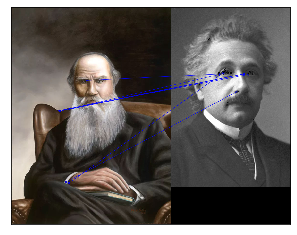

7


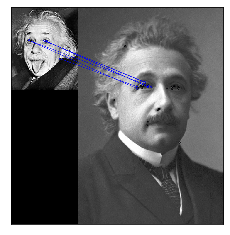

0


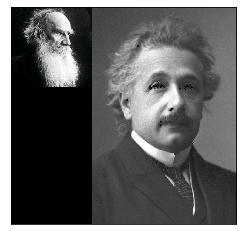

63


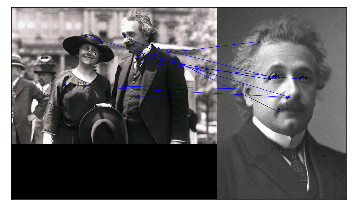

4


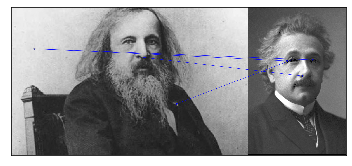

63


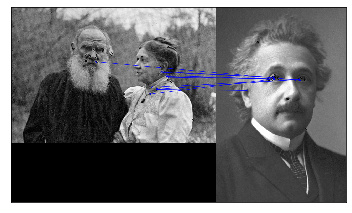

16


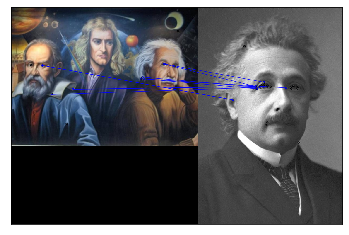

10


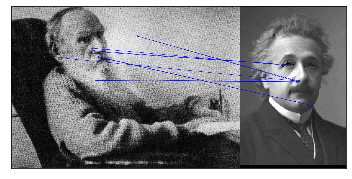

91


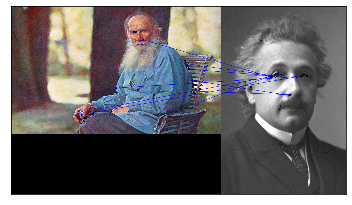

141


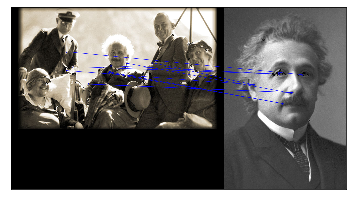

46


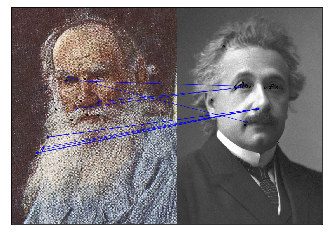

129


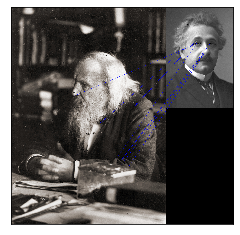

14


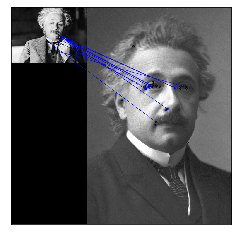

58


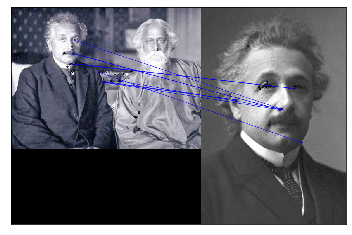

In [64]:
freak = cv2.xfeatures2d.FREAK_create()
ref_copy = np.copy(reference_image)
ref_copy = cv2.cvtColor(ref_copy, cv2.COLOR_BGR2GRAY)
ref_keypoints, ref_desc = freak.compute(ref_copy, ref_keypoints)
bfmatcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

for label in images.keys():
    test_kps, test_desc = freak.compute(images[label], images_keypoints[label])
    matches = bfmatcher.match(test_desc, ref_desc)
    matches = sorted(matches, key = lambda x:x.distance)
    image_matches = cv2.drawMatches(images[label], test_kps, ref_copy, ref_keypoints, matches[:10], ref_copy, (255, 0, 0), 2)
    print(len(matches))
    show_image(image_matches)
    plt.show()

In [ ]:
ref_keypoints

### Final report:
The code seems to be working, try tuning the parameters for the images. 

Some possible resources:

1. https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html
2. http://www.pyimagesearch.com/2015/07/16/where-did-sift-and-surf-go-in-opencv-3/
3. https://github.com/kobejohn/python_brisk_demo/blob/master/brisk_demo.py
4. https://github.com/kobejohn/python_brisk_demo/blob/master/brisk_demo.py
5. https://gist.github.com/Jinqiang/8133713